In [17]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import cv2
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tqdm import tqdm

## Loading Data

In [18]:
nm_shp = gpd.read_file("JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file("JamaicaMangroveLabelsFixed.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [19]:
src = rasterio.open("JamaicaFeaturesNoSAR.tif") 
mask_src = rasterio.open("JamaicaImageMask.tif") 
m_image, m_transform = mask(src, m_geoms, crop=True) 
nm_image, nm_transform = mask(src, nm_geoms, crop=True)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)

# Reshaping Data

In [20]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1) 
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]
m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

np.concat((up_img[m_idx], up_img[nm_idx]))

x, y (original data)
new_x, new_y (downsampled model training)
up_y = np.concat((up_img[m_idx], up_img[nm_idx]))
(upsampled from downsampled labels)

# Downsampling Methods

In [21]:
def downsampling_2d(img, scale_percent):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    # downsampling image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    return resized

In [22]:
def mask_downsampling(mask, scale_percent):
    img = mask[0]
    resized = downsampling_2d(img, scale_percent)
    return np.array([resized])

In [23]:
def image_downsampling(imgs, scale_percent):
    img_down = []
    for i in range(len(imgs)):
        img_new = downsampling_2d(imgs[i], scale_percent)
        img_down.append(img_new)
    img_down = np.array(img_down)
    return img_down 

In [24]:
def upsampling_2d(ori_img, img):
    width_out = ori_img.shape[1]
    height_out = ori_img.shape[0]
    dim_out = (width_out, height_out)
    # upsampling image 
    resized = cv2.resize(img, dim_out, interpolation = cv2.INTER_NEAREST)
    return resized

In [25]:
def mask_upsampling(ori_mask, mask):
    img = mask[0]
    ori_img = ori_mask[0]
    resized = upsampling_2d(ori_img, img)
    return np.array([resized])

In [26]:
def image_upsampling(ori_img, imgs):
    img_up = []
    for i in range(len(imgs)):
        img_new = upsampling_2d(ori_img[i], imgs[i])
        img_up.append(img_new)
    img_up = np.array(img_up)
    return img_up 

# Train the original image

In [11]:
ert_model = ExtraTreesClassifier(n_jobs=4)
ert_model.fit(x_train, y_train)

ExtraTreesClassifier(n_jobs=4)

In [12]:
img_o = reshape_as_image(src.read())
array_o = img_o.reshape(img_o.shape[0] * img_o.shape[1], img_o.shape[2])
output_o = ert_model.predict(array_o)

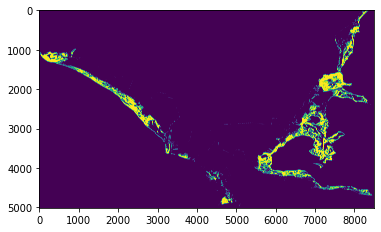

<AxesSubplot:>

In [14]:
output_img_o = output_o.reshape(img_o.shape[0], img_o.shape[1], 1)
show(output_img_o)

In [15]:
np.save('img_o.npy', output_img_o)

## can read the trained image directly here

In [27]:
img_o_load = np.load('img_o.npy')

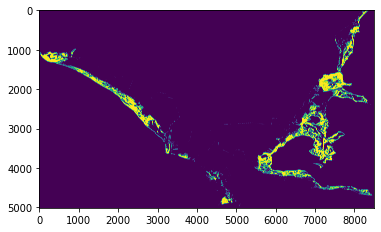

<AxesSubplot:>

In [28]:
show(img_o_load)

# Crop the image with mask

In [15]:
import PIL
from PIL import Image
src_mask_img = Image.open("JamaicaImageMask.tif")
src_mask_img_arr = np.array(src_mask_img)
src_mask_img_arr.shape

(5012, 8500)

In [39]:
#invalid_idx = np.argwhere(src_mask_img_arr == False).tolist()
#invalid_idx 

In [40]:
valid_idx = np.argwhere(src_mask_img_arr == True).tolist()
#valid_idx 

In [41]:
valid_idx_new = np.argwhere(src_mask_img_arr.flatten() == True).flatten().tolist()#.tolist()
valid_idx_new

[8202,
 8203,
 8204,
 8205,
 8206,
 8207,
 8208,
 8209,
 8210,
 8211,
 8212,
 8213,
 8214,
 8215,
 8216,
 8217,
 8218,
 8219,
 8220,
 8221,
 8222,
 8223,
 8224,
 8225,
 8226,
 8227,
 8228,
 8229,
 8230,
 8231,
 8232,
 8233,
 8234,
 8235,
 8236,
 8237,
 8238,
 8239,
 8240,
 8241,
 8242,
 8243,
 8244,
 8245,
 8246,
 8247,
 8248,
 8249,
 8250,
 8251,
 8252,
 8253,
 8254,
 8255,
 8256,
 8257,
 8258,
 8259,
 8260,
 8261,
 8262,
 8263,
 8264,
 8265,
 8266,
 8267,
 8268,
 8269,
 8270,
 8271,
 8272,
 8273,
 8274,
 8275,
 8276,
 8277,
 8278,
 8279,
 8280,
 8281,
 8282,
 8283,
 8284,
 8285,
 8286,
 8287,
 8288,
 8289,
 8290,
 8291,
 8292,
 8293,
 8294,
 8295,
 8296,
 8297,
 8298,
 8299,
 8300,
 8301,
 8302,
 8303,
 8304,
 8305,
 8306,
 8307,
 8308,
 8309,
 8310,
 8311,
 8312,
 8313,
 8314,
 8315,
 8316,
 8317,
 8318,
 8319,
 8320,
 8321,
 8322,
 8323,
 8324,
 8325,
 8326,
 8327,
 8328,
 8329,
 8330,
 8331,
 8332,
 8333,
 8334,
 8335,
 8336,
 8337,
 8338,
 8339,
 8340,
 8341,
 16701,
 16702,
 167

In [37]:
new_o = img_o_load.flatten()
new_o

array([0., 0., 0., ..., 0., 0., 0.])

In [93]:
new_o[valid_idx_new]

array([0., 0., 0., ..., 0., 0., 0.])

In [96]:
#(np.take(new_o, valid_idx_new, 0) == new_o[valid_idx_new]).mean()

1.0

# Scale percentage

In [6]:
nmimg_height_lst = np.linspace(3525/ 5, 3525, num = 20)
nmimg_height_lst

array([ 705.        ,  853.42105263, 1001.84210526, 1150.26315789,
       1298.68421053, 1447.10526316, 1595.52631579, 1743.94736842,
       1892.36842105, 2040.78947368, 2189.21052632, 2337.63157895,
       2486.05263158, 2634.47368421, 2782.89473684, 2931.31578947,
       3079.73684211, 3228.15789474, 3376.57894737, 3525.        ])

In [7]:
scale_percent_lst = nmimg_height_lst/3525
scale_percent_lst 

array([0.2       , 0.24210526, 0.28421053, 0.32631579, 0.36842105,
       0.41052632, 0.45263158, 0.49473684, 0.53684211, 0.57894737,
       0.62105263, 0.66315789, 0.70526316, 0.74736842, 0.78947368,
       0.83157895, 0.87368421, 0.91578947, 0.95789474, 1.        ])

In [70]:
mini_scale_percent_lst = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18])

# Method for training one lower resolution image

In [8]:
def downsample_method(p):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape original image and downsampling
    ori_img = reshape_as_image(src.read())
    new_img = image_downsampling(src.read(), p)
    new_img = reshape_as_image(new_img)
    array = new_img.reshape(new_img.shape[0] * new_img.shape[1], new_img.shape[2])
    #use down sampled masks and images to create train-test split
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    new_clf = ExtraTreesClassifier(n_jobs=4)
    new_clf.fit(new_x_train, new_y_train)
    output = new_clf.predict(array)
    output_img = output.reshape(new_img.shape[0], new_img.shape[1], 1)
    #upsample calssified image
    ori_img1 = ori_img[:,:,0]
    width_out = ori_img1.shape[1]
    height_out = ori_img1.shape[0]
    dim_out = (width_out, height_out)
    up_img = cv2.resize(output_img[:,:,0], dim_out, interpolation = cv2.INTER_NEAREST)
    return up_img

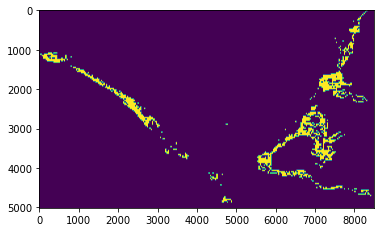

<AxesSubplot:>

In [59]:
show(downsample_method(0.03))

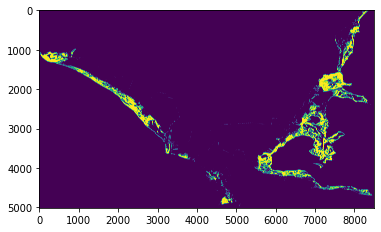

<AxesSubplot:>

In [79]:
show(output_img_o)

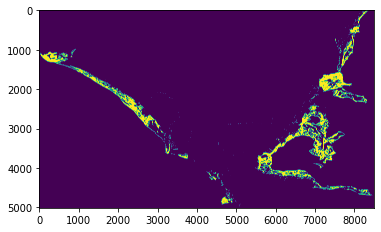

<AxesSubplot:>

In [78]:
show(downsample_method(0.2))

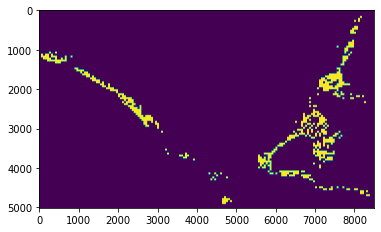

<AxesSubplot:>

In [47]:
show(downsample_method(0.02))

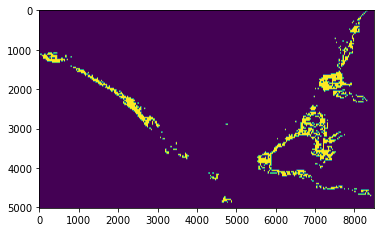

<AxesSubplot:>

In [49]:
show(downsample_method(0.03))

# Fix mask issue

In [ ]:
a4 = downsample_method(0.04)

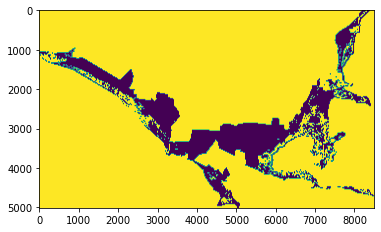

<AxesSubplot:>

In [76]:
show(a4)

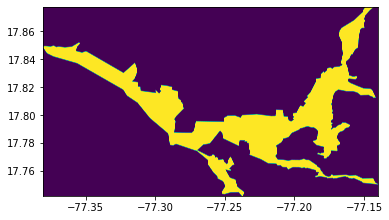

<AxesSubplot:>

In [63]:
show(mask_src)

In [35]:
import PIL
from PIL import Image
src_mask_img = Image.open("JamaicaImageMask.tif")
src_mask_img_arr = np.array(src_mask_img)
src_mask_img_arr.shape

(5012, 8500)

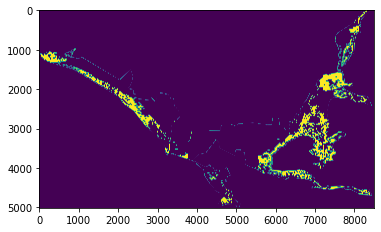

<AxesSubplot:>

In [80]:
show(src_mask_img_arr*a4)

In [82]:
new_a4 = src_mask_img_arr*a4

In [83]:
f1_score(output_img_o.flatten(), new_a4.flatten())

0.7378705650925502

# Trained images with different resolutions

In [25]:
img_lst = []
for p in tqdm(scale_percent_lst):
    img_lst.append(downsample_method(p))

100%|███████████████████████████████████████████| 20/20 [18:40<00:00, 56.02s/it]


In [30]:
mini_img_lst = []
for p in tqdm(mini_scale_percent_lst):
    mini_img_lst.append(downsample_method(p))

100%|█████████████████████████████████████████████| 9/9 [00:23<00:00,  2.58s/it]


In [31]:
img_lst

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 arr

In [32]:
np.save('img_lst.npy', img_lst)

In [31]:
np.save('mini_img_lst.npy', mini_img_lst)

## can load the trained image lists directly here

In [29]:
img_load = np.load('img_lst.npy')

In [32]:
mini_img_load = np.load('mini_img_lst.npy')

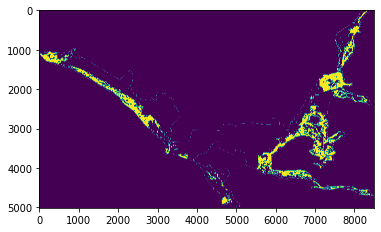

<AxesSubplot:>

In [83]:
show(mini_img_load[2]*src_mask_img_arr)

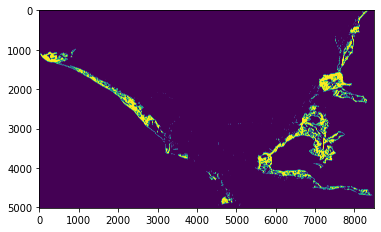

<AxesSubplot:>

In [74]:
show(img_load[0])

# Confusion matix 
(true positive rate, true negative rate, accuracy, F1 score)

In [33]:
#true_postive rate -- sensitivity, recall, tp/(tp+fn)
#true_negative rate -- specificity tn/(tn+fp)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

- Top left quadrant = True Positives = Number of benign labelled as benign
- Bottom right quadrant = True Negatives = Number of malignant labelled as malignant
- Top right quadrant = False Positives = Number of benign labelled as malignant
- Bottom left quadrant = False Negatives = Number of malignant labelled as benign

# compute true positive and true negative

In [40]:
true_postive_rate_lst = []
true_negative_rate_lst = []
for up_img in tqdm(img_load):
    new_up_img = src_mask_img_arr*up_img
    new_c = confusion_matrix(output_img_o.flatten(), new_up_img.flatten())
    TP = new_c[0, 0]
    FP = new_c[0, 1]
    FN = new_c[1, 0]
    TN = new_c[1, 1]
    new_true_positive_rate = TP/(TP+FN)
    new_true_negative_rate = TN/(TN+FP)
    true_postive_rate_lst.append(new_true_positive_rate)
    true_negative_rate_lst.append(new_true_negative_rate)

100%|███████████████████████████████████████████| 20/20 [06:25<00:00, 19.27s/it]


In [41]:
true_postive_rate_lst

[0.9940695606699155,
 0.9955644072150862,
 0.9959752404446999,
 0.9961550155012908,
 0.9961661096879143,
 0.9964431610947005,
 0.9966905275562217,
 0.9966767832680593,
 0.9968101734366228,
 0.9968672327199529,
 0.9968459843660192,
 0.9969895274606548,
 0.9969629915950214,
 0.997016030789903,
 0.9971607804096907,
 0.997038366407958,
 0.9972533571424972,
 0.9971354059644653,
 0.9971749241040817,
 0.9989786821018937]

In [42]:
true_negative_rate_lst

[0.915060165099057,
 0.9025062327011489,
 0.9084500197023748,
 0.9110678469984215,
 0.9209963401451376,
 0.9270559005919604,
 0.9209123347984453,
 0.9265720731486933,
 0.9283766376263927,
 0.9283273237039775,
 0.928391394312579,
 0.93044234189818,
 0.9319820467434257,
 0.9318768576951735,
 0.9295444594752268,
 0.9324280968179166,
 0.933428698074535,
 0.9336237924948914,
 0.9325516543048536,
 0.9763126702017602]

# Compute Accuracy

In [13]:
#Old acc list without removing invalid pixel
# acc_lower_bound_lst = []
# for up_img in img_load:
#     new_up_img = src_mask_img_arr*up_img
#     acc_lower_bound_lst.append((output_img_o.flatten()==new_up_img.flatten()).mean()*96.26)

In [56]:
(img_load[-1].flatten()[valid_idx_new] == new_o.flatten()[valid_idx_new]).mean()

0.9885611532910159

In [85]:
new_acc_lower_bound_lst = []
for up_img in img_load:
    new_up_img = src_mask_img_arr*up_img
    new_acc_lower_bound_lst.append((new_o[valid_idx_new]==new_up_img.flatten()[valid_idx_new]).mean())#*96.26)

In [86]:
new_acc_lower_bound_lst = (np.array(new_acc_lower_bound_lst)*0.9626).tolist()
new_acc_lower_bound_lst

[0.91185693913214,
 0.9161857114684008,
 0.9196952818704335,
 0.9212390342542189,
 0.9237594299854668,
 0.9266356353119065,
 0.9263619458780626,
 0.9276943988207169,
 0.9288108864039815,
 0.9290867088290292,
 0.9289952568311641,
 0.9302253261960337,
 0.9304690204410734,
 0.9307120481263619,
 0.9308693562276458,
 0.9309605416016102,
 0.932297127214722,
 0.931746282236328,
 0.9316833589958146,
 0.9515889661579319]

In [78]:
#Old acc list without removing invalid pixel
# mini_acc_lower_bound_lst = []
# for up_img in mini_img_lst:
#     new_up_img = src_mask_img_arr*up_img
#     mini_acc_lower_bound_lst.append((output_img_o.flatten()==new_up_img.flatten()).mean()*96.26)

In [67]:
new_mini_acc_lower_bound_lst = []
for up_img in mini_img_load:
    new_up_img = src_mask_img_arr*up_img
    new_mini_acc_lower_bound_lst.append((new_o[valid_idx_new]==new_up_img.flatten()[valid_idx_new]).mean())#*96.26)

In [46]:
#mini_acc_lower_bound_lst = (np.array(mini_acc_lower_bound_lst)*0.01).tolist()

In [68]:
new_mini_acc_lower_bound_lst = (np.array(new_mini_acc_lower_bound_lst)*0.9626).tolist()

In [69]:
new_mini_acc_lower_bound_lst

[0.8236842819310927,
 0.843534964569711,
 0.869205780331931,
 0.8818417535354812,
 0.8904626374216865,
 0.8974911100622686,
 0.9042266963481721,
 0.9077666618748597,
 0.9101933393050882]

In [40]:
# old acc_lower_bound_lst 

[95.40195243228017,
 95.47595843622366,
 95.53504484061781,
 95.55975041406508,
 95.60321902774518,
 95.65213534012489,
 95.64675542697526,
 95.6697550640815,
 95.68787866062627,
 95.69376922491902,
 95.69021726210038,
 95.71182955495048,
 95.71699933289517,
 95.7196949382658,
 95.7230616205812,
 95.72361294305432,
 95.74684079151214,
 95.73730110511244,
 95.7373191812591,
 96.07230633115816]

# Compute F1 score

In [15]:
from sklearn.metrics import f1_score

In [44]:
f1_lst = []
for up_img in tqdm(img_lst):
    new_up_img = src_mask_img_arr*up_img
    f1_lst.append(f1_score(output_img_o.flatten(), new_up_img.flatten()))

100%|███████████████████████████████████████████| 20/20 [07:19<00:00, 21.98s/it]


In [45]:
f1_lst

[0.8865121650036638,
 0.8990417557095328,
 0.9068488163358687,
 0.9101053490785037,
 0.9152396968174463,
 0.9215775898658134,
 0.9213975683508534,
 0.9240994976305246,
 0.9264844861230594,
 0.9272965592952641,
 0.926818028007478,
 0.9296454301356689,
 0.9302275616765918,
 0.9306248705330642,
 0.9312708276573358,
 0.9311271827568159,
 0.9342545207796937,
 0.9329246935201402,
 0.9329993593167281,
 0.9759272310809621]

In [49]:
nmimg_height_lst_2 = np.linspace(3525/ 50, 3525, num = 10)
scale_percent_lst_2 = nmimg_height_lst_2/3525
scale_percent_lst_2

array([0.02      , 0.12888889, 0.23777778, 0.34666667, 0.45555556,
       0.56444444, 0.67333333, 0.78222222, 0.89111111, 1.        ])

In [ ]:
img_lst_2 = []
for p in tqdm(scale_percent_lst_2):
    img_lst.append(downsample_method(p))

 80%|███████████████████████████████████▏        | 8/10 [03:33<01:36, 48.18s/it]

In [ ]:
f1_lst_2 = []
for up_img in tqdm(img_lst_2):
    new_up_img = src_mask_img_arr*up_img
    f1_lst_2.append(f1_score(output_img_o.flatten(), new_up_img.flatten()))

In [71]:
new_scale_percent_lst = [0.02, 0.03, 0.2 , 0.36842105,0.41052632, 0.49473684, 0.5368421052631579, 0.6631578947368421, 0.8736842105263158, 1]

In [73]:
new_acc_lst = [93.79841520257266, 94.19762916107226, 95.38464452185343, 95.58208575278157,
 95.62786133467912,95.65827671095255,
 95.66526992019155,95.69798322660908,95.72664069761984,96.074493544904]

In [75]:
new_df = pd.DataFrame()

In [44]:
acc_lower_bound_lst = [95.40195243228017,
 95.47595843622366,
 95.53504484061781,
 95.55975041406508,
 95.60321902774518,
 95.65213534012489,
 95.64675542697526,
 95.6697550640815,
 95.68787866062627,
 95.69376922491902,
 95.69021726210038,
 95.71182955495048,
 95.71699933289517,
 95.7196949382658,
 95.7230616205812,
 95.72361294305432,
 95.74684079151214,
 95.73730110511244,
 95.7373191812591,
 96.07230633115816]

In [53]:
f1_lst = [0.8865121650036638,
 0.8990417557095328,
 0.9068488163358687,
 0.9101053490785037,
 0.9152396968174463,
 0.9215775898658134,
 0.9213975683508534,
 0.9240994976305246,
 0.9264844861230594,
 0.9272965592952641,
 0.926818028007478,
 0.9296454301356689,
 0.9302275616765918,
 0.9306248705330642,
 0.9312708276573358,
 0.9311271827568159,
 0.9342545207796937,
 0.9329246935201402,
 0.9329993593167281,
 0.9759272310809621]

In [72]:
scale_percent_lst

array([0.2       , 0.24210526, 0.28421053, 0.32631579, 0.36842105,
       0.41052632, 0.45263158, 0.49473684, 0.53684211, 0.57894737,
       0.62105263, 0.66315789, 0.70526316, 0.74736842, 0.78947368,
       0.83157895, 0.87368421, 0.91578947, 0.95789474, 1.        ])

# Plot
## ⚠️⚠️⚠️ please do not rerun this portion since some of the variables have changed, feel free to create new plots with new blocks

Text(0, 0.5, 'Accuracy')

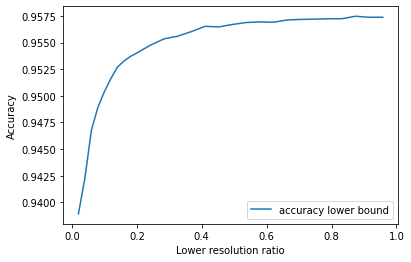

In [83]:
#acc plot not removing invalid pixel
new_df = pd.DataFrame()
new_df['accuracy lower bound'] = mini_acc_lower_bound_lst+acc_lower_bound_lst[:-1]
new_df['Lower resolution ratio'] = mini_scale_percent_lst.tolist()+(scale_percent_lst[:-1]).tolist()
new_df = new_df.set_index('Lower resolution ratio')
new_df.plot(kind='line')
plt.ylabel("Accuracy")
#plt.axvline(0.2, color='green', linestyle='dashed')
#plt.text(0.22, 0.955, 'ratio = 0.2', fontsize=8);

Text(0, 0.5, 'Accuracy')

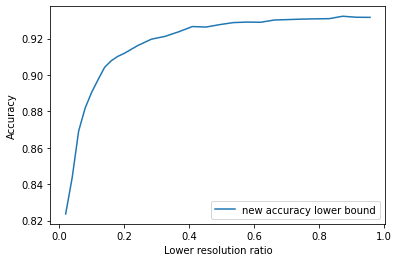

In [89]:
# acc plot after removing invalid pixel
new_df = pd.DataFrame()
new_df['new accuracy lower bound'] = new_mini_acc_lower_bound_lst+new_acc_lower_bound_lst[:-1]
new_df['Lower resolution ratio'] = mini_scale_percent_lst.tolist()+(scale_percent_lst[:-1]).tolist()
new_df = new_df.set_index('Lower resolution ratio')
new_df.plot(kind='line')
plt.ylabel("Accuracy")

In [65]:
acc_lower_bound_lst = (np.array(acc_lower_bound_lst)*0.01).tolist()

Text(0, 0.5, 'percentage')

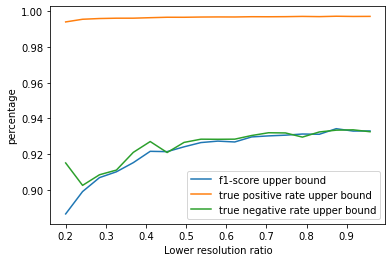

In [68]:
new_df = pd.DataFrame()
#new_df['accuracy lower bound'] = acc_lower_bound_lst[:-1]
new_df['f1-score upper bound'] = f1_lst[:-1]
new_df['true positive rate upper bound'] = true_postive_rate_lst[: -1]
new_df['true negative rate upper bound'] = true_negative_rate_lst[:-1]
new_df['Lower resolution ratio'] = scale_percent_lst[:-1]
new_df = new_df.set_index('Lower resolution ratio')
new_df.plot(kind='line')
plt.ylabel("percentage")
#plt.axvline(0.2, color='green', linestyle='dashed')
#plt.text(0.22, 0.955, 'ratio = 0.2', fontsize=8);

In [59]:
acc_lower_bound_lst

[95.40195243228017,
 95.47595843622366,
 95.53504484061781,
 95.55975041406508,
 95.60321902774518,
 95.65213534012489,
 95.64675542697526,
 95.6697550640815,
 95.68787866062627,
 95.69376922491902,
 95.69021726210038,
 95.71182955495048,
 95.71699933289517,
 95.7196949382658,
 95.7230616205812,
 95.72361294305432,
 95.74684079151214,
 95.73730110511244,
 95.7373191812591,
 96.07230633115816]

In [58]:
f1_lst

[0.8865121650036638,
 0.8990417557095328,
 0.9068488163358687,
 0.9101053490785037,
 0.9152396968174463,
 0.9215775898658134,
 0.9213975683508534,
 0.9240994976305246,
 0.9264844861230594,
 0.9272965592952641,
 0.926818028007478,
 0.9296454301356689,
 0.9302275616765918,
 0.9306248705330642,
 0.9312708276573358,
 0.9311271827568159,
 0.9342545207796937,
 0.9329246935201402,
 0.9329993593167281,
 0.9759272310809621]

In [57]:
true_negative_rate_lst

[0.915060165099057,
 0.9025062327011489,
 0.9084500197023748,
 0.9110678469984215,
 0.9209963401451376,
 0.9270559005919604,
 0.9209123347984453,
 0.9265720731486933,
 0.9283766376263927,
 0.9283273237039775,
 0.928391394312579,
 0.93044234189818,
 0.9319820467434257,
 0.9318768576951735,
 0.9295444594752268,
 0.9324280968179166,
 0.933428698074535,
 0.9336237924948914,
 0.9325516543048536,
 0.9763126702017602]

In [56]:
true_postive_rate_lst

[0.9940695606699155,
 0.9955644072150862,
 0.9959752404446999,
 0.9961550155012908,
 0.9961661096879143,
 0.9964431610947005,
 0.9966905275562217,
 0.9966767832680593,
 0.9968101734366228,
 0.9968672327199529,
 0.9968459843660192,
 0.9969895274606548,
 0.9969629915950214,
 0.997016030789903,
 0.9971607804096907,
 0.997038366407958,
 0.9972533571424972,
 0.9971354059644653,
 0.9971749241040817,
 0.9989786821018937]

# Draft

In [32]:
m_idx.shape

(3101, 4213)

In [33]:
nm_idx.shape

(3525, 7528)

In [34]:
up_img.shape

(5012, 8500)

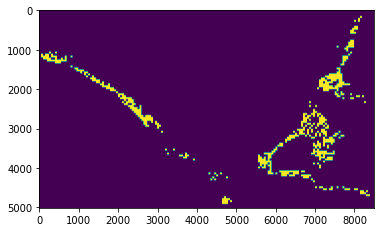

<AxesSubplot:>

In [17]:
show(up_img)

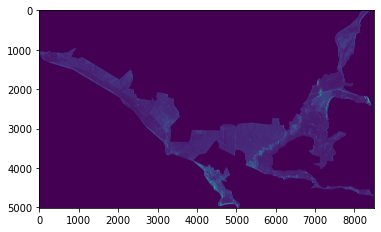

<AxesSubplot:>

In [37]:
show(src.read()[0])

In [19]:
up_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))

In [18]:
up_img.shape

(5012, 8500)

5. Create a training and test set using the upsampled data and the original data using the original sample seed. The y_test from this should become your y_pred.
6. Compare the y_test from 1 and the y_pred from 5

In [ ]:
#reverse ?
new_x2 = np.concatenate((new_x_train, new_x_test), axis = 0)
new_x2
new_y2 = np.concatenate((new_y_train, y_pred), axis = 0)
new_y2

In [15]:
y_test_pred = new_clf.predict(new_x_test)

In [16]:
y_test_pred.shape

(207,)

In [205]:
# ori_img1 = ori_img[:,:,0]
# ori_img1 = ori_img1.reshape(ori_img1.shape[0], ori_img1.shape[1], 1)
# up_img = mask_upsampling(ori_img1, output_img)
# #up_img = up_img.reshape(up_img.shape[1], up_img.shape[2], 1)
# new_acc = (y_pred==y_test).mean()
# new_mmask = mask_upsampling(mmask, new_mmask)
# new_nmmask = mask_upsampling(nmmask, new_nmmask)
# new_m_image = image_upsampling(m_image, new_m_image)
# new_nm_image = image_upsampling(nm_image, new_nm_image)

In [197]:
up_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [195]:
#from CSE 152a
def createSplit(imgList, ratio):
    random.shuffle(imgList)
    trainList = imgList[:round(len(imgList)*ratio)]
    testList = imgList[round(len(imgList)*ratio):]
    return trainList, testList

In [190]:
ori_img1.shape

(5012, 8500)

In [191]:
# width_out = 8500
# height_out = 5012
# dim_out = (width_out, height_out)
# resized = cv2.resize(output_img[:,:,0], dim_out, interpolation = cv2.INTER_NEAREST)

In [192]:
#ori_img1[:,:,0].shape

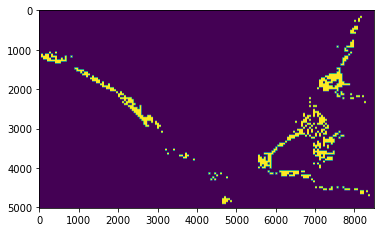

In [194]:
show(up_img);

In [144]:
output_img.shape

(100, 170, 1)

In [149]:
output_img[:,:,0].shape

(100, 170)

In [145]:
ori_img1 = ori_img[:,:,0]
ori_img1 = ori_img1.reshape(ori_img1.shape[0], ori_img1.shape[1], 1)
ori_img1.shape

(5012, 8500, 1)

In [116]:
up_img.shape

(5012, 8500, 1)

In [15]:
new_x2 = np.concatenate((new_x_train, new_x_test), axis = 0)
new_x2
new_y2 = np.concatenate((new_y_train, y_pred), axis = 0)
new_y2


array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
y_pred.shape

(207,)

In [25]:
new_m_image.shape

(9, 62, 84)

In [26]:
new_nm_image.shape

(9, 70, 150)

In [ ]:
y_pred_new = y_pred.reshape(img.shape[0], img.shape[1], 1)
show(y_pred_new)

In [20]:
new_x2.shape

(1033, 9)

In [16]:
new_y2.shape

(1033,)

In [17]:
new_y2.mean()

0.15779283639883834

In [49]:
y_test.mean()

0.1670597883674684

In [50]:
y_pred.mean()

0.14009661835748793

In [51]:
new_mmask.shape

(1, 62, 84)

In [52]:
mmask.shape

(1, 3101, 4213)

In [53]:
new_nmmask.shape

(1, 70, 150)

In [54]:
nmmask.shape

(1, 3525, 7528)

In [55]:
new_m_image.shape

(9, 62, 84)

In [56]:
m_image.shape

(9, 3101, 4213)

In [57]:
new_nm_image.shape

(9, 70, 150)

In [58]:
nm_image.shape

(9, 3525, 7528)

In [59]:
new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
new_x_train2, new_x_test2, new_y_train2, new_y_test2 = train_test_split(new_x, new_y, test_size=0.20, random_state=42)

In [60]:
new_x_train2.shape

(826, 9)

In [61]:
x_train.shape

(2204576, 9)

In [62]:
y_pred = new_clf.predict(new_x_test2)

In [134]:
y_pred

array([1., 0., 0., ..., 0., 0., 0.])

In [135]:
y_test

array([0., 0., 0., ..., 0., 0., 0.])

In [160]:
new_y_test2

array([1., 0., 0., ..., 0., 0., 0.])

In [136]:
new_x.shape

(2606903, 9)

In [137]:
x.shape

(2755720, 9)

In [119]:
len(y_pred)

521381

In [120]:
len(y_test)

551144

In [161]:
len(new_y_test2)

521381

In [63]:
new_acc = np.array(y_pred==y_test).mean()
new_acc

/var/folders/8p/rkfnf83x2xj054q1r8n6xhjm0000gn/T/ipykernel_5225/3343971228.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  new_acc = np.array(y_pred==y_test).mean()


0.0

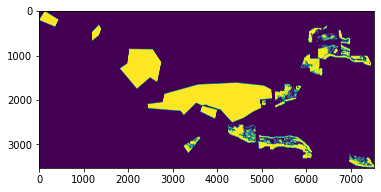

<AxesSubplot:>

In [99]:
show(nmmask)

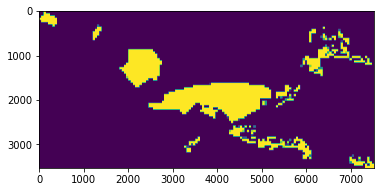

<AxesSubplot:>

In [100]:
show(new_nmmask)

In [101]:
nmmask.shape

(1, 3525, 7528)

In [102]:
new_nmmask.shape

(1, 3525, 7528)

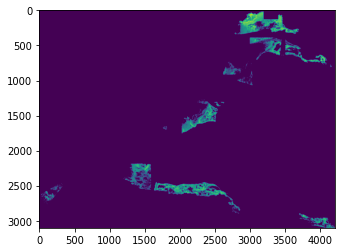

<AxesSubplot:>

In [95]:
show(m_image[7])

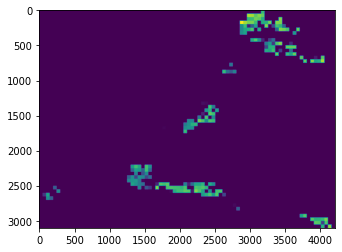

<AxesSubplot:>

In [96]:
show(new_m_image[7])

In [97]:
m_image.shape

(9, 3101, 4213)

In [98]:
new_m_image.shape

(9, 3101, 4213)

# Downsampling

In [4]:
#openCV resize
#https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/

In [5]:
from scipy import ndimage
import matplotlib.pyplot as plt

In [32]:
identity_matrix = np.identity(100)
identity_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

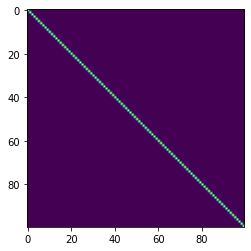

<AxesSubplot:>

In [33]:
show(identity_matrix)

In [34]:
identity_matrix_down = downsampling_2d(identity_matrix, 0.1)

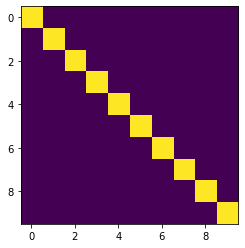

<AxesSubplot:>

In [35]:
show(identity_matrix_down)

In [36]:
identity_matrix_up = upsampling_2d(identity_matrix, identity_matrix_down)

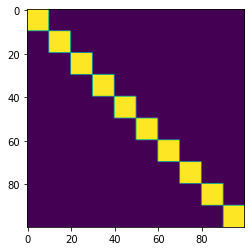

<AxesSubplot:>

In [37]:
show(identity_matrix_up)

In [20]:
def downsampling_and_upsampling_2d(img, scale_percent):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    # downsampling image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    width_out = img.shape[1]
    height_out = img.shape[0]
    dim_out = (width_out, height_out)
    # upsampling image 
    resized = cv2.resize(resized, dim_out, interpolation = cv2.INTER_NEAREST)
    return resized

In [6]:
def mask_downsampling(mask, scale_percent):
    img = mask[0]
    resized = downsampling_2d(img, scale_percent)
    return np.array([resized])

In [7]:
def image_downsampling(imgs, scale_percent):
    img_down = []
    for i in range(len(imgs)):
        img_new = downsampling_2d(imgs[i], scale_percent)
        img_down.append(img_new)
    img_down = np.array(img_down)
    return img_down 

The accuracy should change from that high training accuracy if we are comparing to the original labels

It may be a bit of a convoluted process but here is what I am thinking:

1. Create training and test set of the original imagery (you will only be using the test set for this), use the same sample seed
1. Downsample the training imagery to the lower resolution, create a separate train/test set. (you will only be using the training set for this)
1. Train a model using the downsampled training set
1. Classify the downsampled imagery, reshape it back to the original image, and upsample it
1. Create a training and test set using the upsampled data and the original data using the original sample seed. The y_test from this should become your y_pred.
1. Compare the y_test from 1 and the y_pred from 5

So essentially your y_test is from the original dataset, and y_pred is from the downsampled -> upsampled -> reshaped data from the same indices

In [87]:
mask_downsampling(mmask, 0.32631579).shape

(1, 3101, 4213)

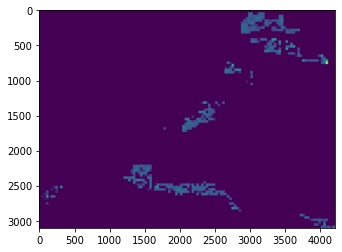

<AxesSubplot:>

In [88]:
show(image_downsampling(m_image, 0.03)[0])

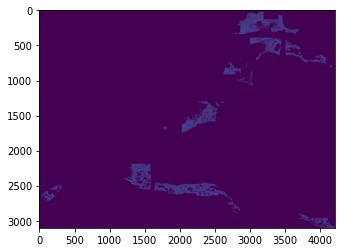

<AxesSubplot:>

In [89]:
show(m_image[0])

In [18]:
mmask.shape

(1, 3101, 4213)

In [31]:
mmask.shape

(1, 3101, 4213)

In [32]:
0.03*3101

93.03

In [136]:
k = mask_downsampling(mmask, 0.01)

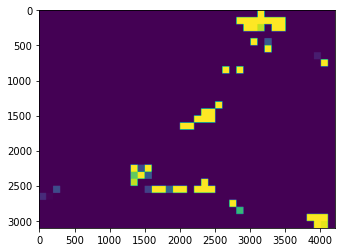

<AxesSubplot:>

In [137]:
show(k)

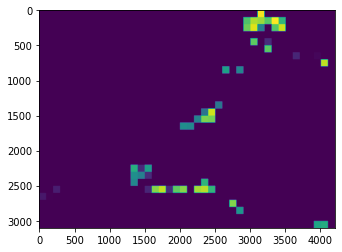

<AxesSubplot:>

In [149]:
show(image_downsampling(m_image, 0.01)[7])

In [151]:
(image_downsampling(m_image, 0.01)[7] == m_image[7]).mean()

0.9451817300805625

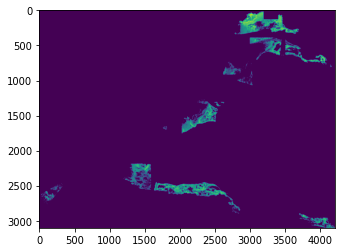

<AxesSubplot:>

In [150]:
show(m_image[7])

In [141]:
(image_downsampling(m_image, 0.01)==m_image).mean()

0.9452067427065807

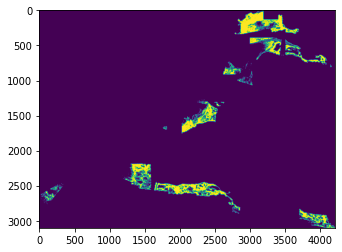

<AxesSubplot:>

In [138]:
show(mmask)

In [90]:
mask_downsampling(nmmask, 0.95789474).shape

(1, 3525, 7528)

In [24]:
nmmask.shape

(1, 3525, 7528)

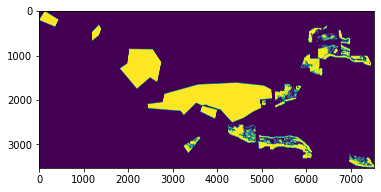

<AxesSubplot:>

In [152]:
show(nmmask)

In [25]:
7528*0.95789474

7211.03160272

In [22]:
3101*0.95789474

2970.43158874

In [9]:
nm_image.shape

(9, 3525, 7528)

In [17]:
nmimg_height_lst = np.linspace(3525/ 5, 3525, num = 20)
nmimg_height_lst

array([ 705.        ,  853.42105263, 1001.84210526, 1150.26315789,
       1298.68421053, 1447.10526316, 1595.52631579, 1743.94736842,
       1892.36842105, 2040.78947368, 2189.21052632, 2337.63157895,
       2486.05263158, 2634.47368421, 2782.89473684, 2931.31578947,
       3079.73684211, 3228.15789474, 3376.57894737, 3525.        ])

In [18]:
scale_percent_lst = nmimg_height_lst/3525
scale_percent_lst 

array([0.2       , 0.24210526, 0.28421053, 0.32631579, 0.36842105,
       0.41052632, 0.45263158, 0.49473684, 0.53684211, 0.57894737,
       0.62105263, 0.66315789, 0.70526316, 0.74736842, 0.78947368,
       0.83157895, 0.87368421, 0.91578947, 0.95789474, 1.        ])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [9]:
from tqdm import tqdm

In [10]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1) 
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]
m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [60]:
clf = ExtraTreesClassifier(n_jobs=4)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc = (y_pred==y_test).mean()
acc

0.9626086830302063

In [16]:
for p in (scale_percent_lst):
    print(p)

0.2
0.24210526315789474
0.28421052631578947
0.3263157894736842
0.368421052631579
0.4105263157894737
0.45263157894736844
0.4947368421052632
0.5368421052631579
0.5789473684210527
0.6210526315789474
0.6631578947368421
0.7052631578947369
0.7473684210526317
0.7894736842105263
0.8315789473684211
0.8736842105263158
0.9157894736842106
0.9578947368421054
1.0


In [13]:
p =  0.01
new_mmask = mask_downsampling(mmask, p)
new_nmmask = mask_downsampling(nmmask, p)
new_m_image = image_downsampling(m_image, p)
new_nm_image = image_downsampling(nm_image, p)

In [14]:
new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)

In [15]:
new_clf = ExtraTreesClassifier(n_jobs=4)
new_clf.fit(new_x_train, new_y_train)
new_y_pred = new_clf.predict(new_x_test)
acc = (new_y_pred==new_y_test).mean()
acc

1.0

In [38]:
new_y_test

array([0., 0., 0., ..., 0., 1., 0.])

In [37]:
new_y_pred == 

array([0., 0., 0., ..., 0., 1., 0.])

In [24]:
y_test_1 = np.array([y_test])

In [25]:
width_out = y_test_1.shape[1]
height_out = y_test_1.shape[0]
dim_out = (width_out, height_out)
dim_out

(551144, 1)

In [34]:
new_y_pred2 = cv2.resize(new_y_pred, dim_out, interpolation = cv2.INTER_NEAREST)

In [35]:
new_y_test2 = cv2.resize(new_y_test, dim_out, interpolation = cv2.INTER_NEAREST)

In [36]:
(new_y_pred2[0]==new_y_test2[0]).mean()

1.0

In [160]:
len(x_test)

551144

In [161]:
len(new_y_pred)

520677

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    459070
         1.0       0.89      0.89      0.89     92074

    accuracy                           0.96    551144
   macro avg       0.93      0.93      0.93    551144
weighted avg       0.96      0.96      0.96    551144



In [77]:
print(classification_report(y_test, new_y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    459070
         1.0       0.97      0.97      0.97     92074

    accuracy                           0.99    551144
   macro avg       0.98      0.98      0.98    551144
weighted avg       0.99      0.99      0.99    551144



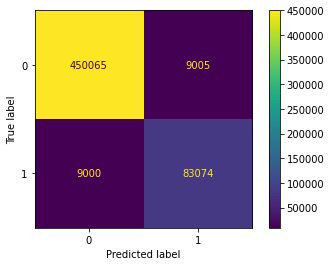

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, new_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [19]:
def downsampling_2d(img, scale_percent):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    # downsampling image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    width_out = img.shape[1]
    height_out = img.shape[0]
    dim_out = (width_out, height_out)
    # upsampling image 
    resized = cv2.resize(resized, dim_out, interpolation = cv2.INTER_NEAREST)
    return resized
def mask_downsampling(mask, scale_percent):
    img = mask[0]
    resized = downsampling_2d(img, scale_percent)
    return np.array([resized])
def image_downsampling(imgs, scale_percent):
    img_down = []
    for i in range(len(imgs)):
        img_new = downsampling_2d(imgs[i], scale_percent)
        img_down.append(img_new)
    img_down = np.array(img_down)
    return img_down 

In [22]:
from tqdm import tqdm
from sklearn.metrics import f1_score

In [23]:
acc_lst = []
for p in tqdm(scale_percent_lst):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    #train with ERT
    new_clf = ExtraTreesClassifier(n_jobs=4)
    new_clf.fit(new_x_train, new_y_train)
    y_pred = new_clf.predict(x_test)
    #new_acc = (y_pred==y_test).mean()
    #print(new_acc)
    #acc_lst.append(new_acc)
    new_f1 = f1_score(y_test, y_pred)
    print(new_f1)
    acc_lst.append(new_f1)

  5%|██▏                                         | 1/20 [00:37<11:55, 37.67s/it]

0.873365068066554


 10%|████▍                                       | 2/20 [01:13<11:01, 36.76s/it]

0.8792736264753781


 15%|██████▌                                     | 3/20 [01:52<10:40, 37.70s/it]

0.8809108068560736


 20%|████████▊                                   | 4/20 [02:29<09:56, 37.26s/it]

0.8837636971022534


 25%|███████████                                 | 5/20 [03:10<09:41, 38.74s/it]

0.8852742425642726


 30%|█████████████▏                              | 6/20 [03:51<09:13, 39.55s/it]

0.8864567297492832


 35%|███████████████▍                            | 7/20 [04:32<08:41, 40.09s/it]

0.8884891499872288


 40%|█████████████████▌                          | 8/20 [05:18<08:22, 41.85s/it]

0.8899265597225469


 45%|███████████████████▊                        | 9/20 [05:59<07:38, 41.70s/it]

0.8908944609964552


 50%|█████████████████████▌                     | 10/20 [06:45<07:10, 43.00s/it]

0.8923465005273402


 55%|███████████████████████▋                   | 11/20 [07:27<06:23, 42.60s/it]

0.8936896210729927


 60%|█████████████████████████▊                 | 12/20 [08:19<06:04, 45.58s/it]

0.8955724726605346


 65%|███████████████████████████▉               | 13/20 [09:01<05:11, 44.43s/it]

0.8959359572469001


 70%|██████████████████████████████             | 14/20 [09:47<04:29, 44.84s/it]

0.896829489385493


 75%|████████████████████████████████▎          | 15/20 [10:41<03:58, 47.61s/it]

0.8985066851884007


 80%|██████████████████████████████████▍        | 16/20 [11:57<03:44, 56.06s/it]

0.8989488772097467


 85%|████████████████████████████████████▌      | 17/20 [13:02<02:56, 58.86s/it]

0.9002921404446182


 90%|██████████████████████████████████████▋    | 18/20 [14:07<02:01, 60.61s/it]

0.9016182529816352


 95%|████████████████████████████████████████▊  | 19/20 [15:02<00:59, 59.08s/it]

0.9021144920061888


100%|███████████████████████████████████████████| 20/20 [16:07<00:00, 48.37s/it]

0.8887648244910348


In [ ]:
new_acc_lst2 = []
for p in tqdm(scale_percent_lst):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    #train with ERT
    new_clf = ExtraTreesClassifier(n_jobs=4)
    new_clf.fit(new_x_train, new_y_train)
    new_y_pred = new_clf.predict(new_x_test)
    new_acc = (new_y_pred==new_y_test).mean()
    print(new_acc)
    new_acc_lst2.append(new_acc)

In [ ]:
acc_lst

In [11]:
new_nmimg_height_lst = np.linspace(3525/ 100, 3525, num = 20)
new_nmimg_height_lst

array([  35.25      ,  218.92105263,  402.59210526,  586.26315789,
        769.93421053,  953.60526316, 1137.27631579, 1320.94736842,
       1504.61842105, 1688.28947368, 1871.96052632, 2055.63157895,
       2239.30263158, 2422.97368421, 2606.64473684, 2790.31578947,
       2973.98684211, 3157.65789474, 3341.32894737, 3525.        ])

In [12]:
new_scale_percent_lst = new_nmimg_height_lst/3525
new_scale_percent_lst 

array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [15]:
new_acc_lst = []
for p in tqdm(new_scale_percent_lst):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    #train with XGBoost
    new_xgb_model = XGBClassifier()
    new_xgb_model.fit(new_x_train, new_y_train)
    y_pred = new_xgb_model.predict(x_test)
    new_acc = (y_pred==y_test).mean()
    print(new_acc)
    new_acc_lst.append(new_acc)

  5%|██▏                                         | 1/20 [00:00<00:02,  9.02it/s]

0.9328723527789471


 10%|████▍                                       | 2/20 [00:00<00:07,  2.43it/s]

0.9541299551478379


 15%|██████▌                                     | 3/20 [00:02<00:14,  1.19it/s]

0.9560332689823349


 20%|████████▊                                   | 4/20 [00:04<00:23,  1.45s/it]

0.956978575472109


 25%|███████████                                 | 5/20 [00:08<00:34,  2.30s/it]

0.9579964582758771


 30%|█████████████▏                              | 6/20 [00:13<00:48,  3.44s/it]

0.9579946438680272


 35%|███████████████▍                            | 7/20 [00:21<01:03,  4.88s/it]

0.9585171933287853


 40%|█████████████████▌                          | 8/20 [00:32<01:19,  6.60s/it]

0.9590342995659936


 45%|███████████████████▊                        | 9/20 [00:44<01:33,  8.53s/it]

0.9590560724601919


 50%|█████████████████████▌                     | 10/20 [01:00<01:46, 10.70s/it]

0.9593754082417663


 55%|███████████████████████▋                   | 11/20 [01:19<01:58, 13.14s/it]

0.9594969735677065


 60%|█████████████████████████▊                 | 12/20 [01:42<02:09, 16.14s/it]

0.9597292177724878


 65%|███████████████████████████▉               | 13/20 [02:09<02:17, 19.66s/it]

0.9595078600148056


 70%|██████████████████████████████             | 14/20 [02:43<02:22, 23.81s/it]

0.9597165169175388


 75%|████████████████████████████████▎          | 15/20 [03:23<02:24, 28.86s/it]

0.9597890932315329


 80%|██████████████████████████████████▍        | 16/20 [04:10<02:17, 34.37s/it]

0.9597709491530344


 85%|████████████████████████████████████▌      | 17/20 [05:08<02:04, 41.45s/it]

0.9599832348714673


 90%|██████████████████████████████████████▋    | 18/20 [06:16<01:38, 49.26s/it]

0.9599015865182239


 95%|████████████████████████████████████████▊  | 19/20 [07:35<00:58, 58.29s/it]

0.9603297867707895


100%|███████████████████████████████████████████| 20/20 [09:10<00:00, 27.54s/it]

0.9592901310728231


In [107]:
new_acc_lst = []
for p in tqdm(new_scale_percent_lst):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    #train with ERT
    new_clf = ExtraTreesClassifier(n_jobs=4)
    new_clf.fit(new_x_train, new_y_train)
    y_pred = new_clf.predict(x_test)
    new_acc = (y_pred==y_test).mean()
    print(new_acc)
    new_acc_lst.append(new_acc)

  5%|██▏                                         | 1/20 [00:18<05:44, 18.12s/it]

0.9425939500384655


 10%|████▍                                       | 2/20 [00:48<07:31, 25.08s/it]

0.9553564948543394


 15%|██████▌                                     | 3/20 [01:20<08:04, 28.53s/it]

0.957301540069383


 20%|████████▊                                   | 4/20 [01:52<07:59, 30.00s/it]

0.9584881628031876


 25%|███████████                                 | 5/20 [02:26<07:50, 31.34s/it]

0.9595985804072983


 30%|█████████████▏                              | 6/20 [03:00<07:30, 32.18s/it]

0.9602354375625971


 35%|███████████████▍                            | 7/20 [03:35<07:10, 33.09s/it]

0.9610646219499804


 40%|█████████████████▌                          | 8/20 [04:10<06:45, 33.75s/it]

0.9617305096308769


 45%|███████████████████▊                        | 9/20 [04:46<06:17, 34.33s/it]

0.9623419650762777


 50%|█████████████████████▌                     | 10/20 [05:21<05:47, 34.75s/it]

0.9630405120984715


 55%|███████████████████████▋                   | 11/20 [05:56<05:12, 34.71s/it]

0.9639059846428519


 60%|█████████████████████████▊                 | 12/20 [06:33<04:42, 35.33s/it]

0.9641128271377353


 65%|███████████████████████████▉               | 13/20 [07:10<04:10, 35.76s/it]

0.9643704730524146


 70%|██████████████████████████████             | 14/20 [07:45<03:34, 35.80s/it]

0.9651923998083985


 75%|████████████████████████████████▎          | 15/20 [08:22<03:00, 36.13s/it]

0.9655661678254684


 80%|██████████████████████████████████▍        | 16/20 [08:59<02:25, 36.34s/it]

0.9659054620933912


 85%|████████████████████████████████████▌      | 17/20 [09:37<01:50, 36.86s/it]

0.9663137038596084


 90%|██████████████████████████████████████▋    | 18/20 [10:14<01:13, 36.95s/it]

0.9667092447708766


 95%|████████████████████████████████████████▊  | 19/20 [10:53<00:37, 37.56s/it]

0.9672227221923853


100%|███████████████████████████████████████████| 20/20 [11:38<00:00, 34.93s/it]

0.9626431567793535


In [15]:
y_test_1 = np.array([y_test])
width_out = y_test_1.shape[1]
height_out = y_test_1.shape[0]
dim_out = (width_out, height_out)

In [17]:
y_pred_1= cv2.resize(y_pred, dim_out, interpolation = cv2.INTER_NEAREST)

NameError: name 'y_pred' is not defined

In [20]:
cv2.resize(np.identity(2), dim_out, interpolation = cv2.INTER_NEAREST)[0]

array([1., 1., 1., ..., 0., 0., 0.])

In [26]:
new_acc_lst = []
for p in tqdm(new_scale_percent_lst):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    #train with ERT
    new_clf = ExtraTreesClassifier(n_jobs=4)
    new_clf.fit(new_x_train, new_y_train)
    new_y_pred = new_clf.predict(new_x_test)
    new_y_pred_1= cv2.resize(new_y_pred, dim_out, interpolation = cv2.INTER_NEAREST)
    new_acc = (new_y_pred_1[0]==y_test).mean()
    print(new_acc)
    new_acc_lst.append(new_acc)

 10%|████▍                                       | 2/20 [00:00<00:02,  8.87it/s]

0.1670597883674684
0.8329402116325316


 15%|██████▌                                     | 3/20 [00:00<00:03,  5.49it/s]

0.1670597883674684


 20%|████████▊                                   | 4/20 [00:01<00:05,  2.98it/s]

0.8329402116325316


 25%|███████████                                 | 5/20 [00:02<00:08,  1.81it/s]

0.8329402116325316


 30%|█████████████▏                              | 6/20 [00:03<00:11,  1.20it/s]

0.8329402116325316


 35%|███████████████▍                            | 7/20 [00:05<00:16,  1.24s/it]

0.8329402116325316


 40%|█████████████████▌                          | 8/20 [00:08<00:21,  1.80s/it]

0.8329402116325316


 45%|███████████████████▊                        | 9/20 [00:12<00:28,  2.61s/it]

0.8329402116325316


 50%|█████████████████████▌                     | 10/20 [00:19<00:37,  3.78s/it]

0.8329402116325316


 55%|███████████████████████▋                   | 11/20 [00:27<00:45,  5.05s/it]

0.8329402116325316


 60%|█████████████████████████▊                 | 12/20 [00:37<00:53,  6.66s/it]

0.8329402116325316


 65%|███████████████████████████▉               | 13/20 [00:50<00:59,  8.56s/it]

0.1670597883674684


 70%|██████████████████████████████             | 14/20 [01:05<01:03, 10.51s/it]

0.1670597883674684


 70%|██████████████████████████████             | 14/20 [01:14<00:31,  5.33s/it]


KeyboardInterrupt: 

In [114]:
new_df = pd.DataFrame()

In [117]:
new_scale_percent_lst

array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])

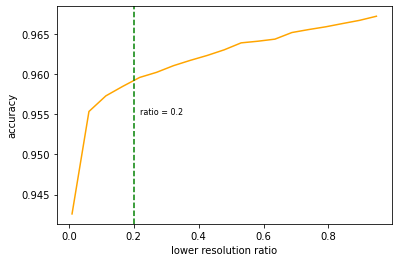

In [135]:
plt.plot(new_scale_percent_lst[:-1], new_acc_lst[:-1], color = 'orange')
plt.ylabel("accuracy")
plt.xlabel("lower resolution ratio")
plt.axvline(0.2, color='green', linestyle='dashed')
plt.text(0.22, 0.955, 'ratio = 0.2', fontsize=8);

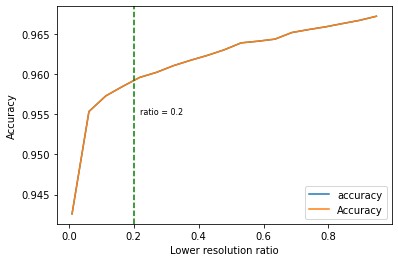

In [131]:
new_df['accuracy'] = new_acc_lst[:-1]
new_df['Lower resolution ratio'] = new_scale_percent_lst[:-1]
new_df = new_df.set_index('Lower resolution ratio')
new_df.plot(kind='line')
plt.ylabel("Accuracy")
plt.axvline(0.2, color='green', linestyle='dashed')
plt.text(0.22, 0.955, 'ratio = 0.2', fontsize=8);

In [108]:
new_acc_lst1 = []
for p in tqdm(new_scale_percent_lst):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    #train with ERT
    new_clf = ExtraTreesClassifier(n_jobs=4)
    new_clf.fit(new_x_train, new_y_train)
    new_y_pred = new_clf.predict(new_x_test)
    new_acc = (new_y_pred==new_y_test).mean()
    print(new_acc)
    new_acc_lst1.append(new_acc)

  5%|██▏                                         | 1/20 [00:17<05:24, 17.08s/it]

1.0


 10%|████▍                                       | 2/20 [00:46<07:17, 24.31s/it]

1.0


 15%|██████▌                                     | 3/20 [01:16<07:36, 26.85s/it]

1.0


 20%|████████▊                                   | 4/20 [01:48<07:41, 28.83s/it]

1.0


 20%|████████▊                                   | 4/20 [01:57<07:49, 29.31s/it]


KeyboardInterrupt: 

The accuracy should change from that high training accuracy if we are comparing to the original labels

It may be a bit of a convoluted process but here is what I am thinking:

1. Create training and test set of the original imagery (you will only be using the test set for this), use the same sample seed
1. Downsample the training imagery to the lower resolution, create a separate train/test set. (you will only be using the training set for this)
1. Train a model using the downsampled training set
1. Classify the downsampled imagery, reshape it back to the original image, and upsample it
1. Create a training and test set using the upsampled data and the original data using the original sample seed. The y_test from this should become your y_pred.
1. Compare the y_test from 1 and the y_pred from 5

So essentially your y_test is from the original dataset, and y_pred is from the downsampled -> upsampled -> reshaped data from the same indices

In [ ]:
#1. Create training and test set of the original imagery 
#(you will only be using the test set for this), use the same sample seed
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1) 
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]
m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))
#get all the pix of mangrove
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#2. Downsample the training imagery to the lower resolution, 
#create a separate train/test set. (you will only be using the training set for this)
#downsampling masks and images
p = 0.02
new_mmask = mask_downsampling(mmask, p)
new_nmmask = mask_downsampling(nmmask, p)
new_m_image = image_downsampling(m_image, p)
new_nm_image = image_downsampling(nm_image, p)
#reshape original image and downsampling
ori_img = reshape_as_image(src.read())
new_img = image_downsampling(src.read(), p)
new_img = reshape_as_image(new_img)
array = new_img.reshape(new_img.shape[0] * new_img.shape[1], new_img.shape[2])
#use down sampled masks and images to create train-test split
new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
#didn't match

#3. Train a model using the downsampled training set
#train with ERT on training set of the downsample image
new_clf = ExtraTreesClassifier(n_jobs=4)
new_clf.fit(new_x_train, new_y_train)

#4. Classify the downsampled imagery, reshape it back to the original image, and upsample it
#classify downsampled image
output = new_clf.predict(array)
output_img = output.reshape(new_img.shape[0], new_img.shape[1], 1)
#upsample calssified image
ori_img1 = ori_img[:,:,0]
width_out = ori_img1.shape[1]
height_out = ori_img1.shape[0]
dim_out = (width_out, height_out)
up_img = cv2.resize(output_img[:,:,0], dim_out, interpolation = cv2.INTER_NEAREST)
#how to create train test split with this single image?
#reform the y
#compare original y and 
#ori_y and up_y
#slicing 

np.concat((up_img[m_idx], up_img[nm_idx]))

x, y (original data)
new_x, new_y (downsampled model training)
up_y = np.concat((up_img[m_idx], up_img[nm_idx]))
(upsampled from downsampled labels)